# Install detectron2

In [1]:
#dependencies
!pip install --upgrade pip
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
torchvision.__version__
!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

     |████████████████████████████████| 1.4MB 7.2MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 42 kB/s s eta 0:00:013��███████               | 384.3 MB 113.7 MB/s eta 0:00:03��██████████████    | 632.1 MB 78.1 MB/s eta 0:00:02��████████████████████████▏   | 636.1 MB 78.1 MB/s eta 0:00:02████████████████████████████▉ | 696.7 MB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 650 kB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2
     |████████████████████████████████| 274 kB 7.2 MB/s eta

  Created wheel for fvcore: filename=fvcore-0.1.dev200308-py3-none-any.whl size=37813 sha256=5f9260ab001da7653a05243bf537dc4ca281e259f2a80f7617301d24dd92568d
  Stored in directory: /home/Deep_Learner/.cache/pip/wheels/f0/c8/fa/13d4d380de3f4b1b947850bdddab77dc1874d06c107b9a2e76
Successfully built fvcore


# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util

from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from tqdm import tqdm_notebook as tqdm
import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split

 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
EXTRA_DATA = PATH/'extra_data'
STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution.csv'


seed = 19
np.random.seed(seed)

# util functions

In [2]:
def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    masks = [open_mask_as_np(p) for p in path.ls()]
    return merge_masks(masks, shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

#!pip install imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# dataset

## load csv

In [31]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

## Custom dataset for detectron2

### Example custom dataset balloons (https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=4Qg7zSVOulkb)

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

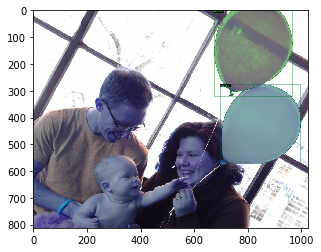

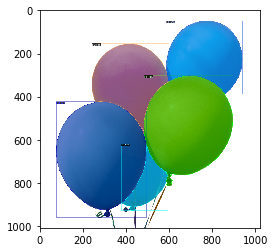

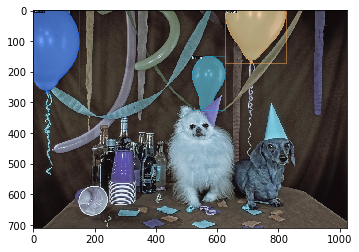

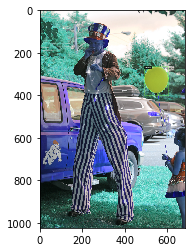

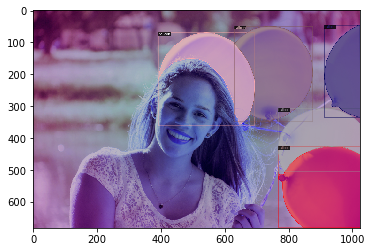

In [20]:
dataset_dicts_balloons = get_balloon_dicts("./balloon/train")
##for d in random.sample(dataset_dicts_balloons, 3):
for d in dataset_dicts_balloons[15:20]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

In [21]:
dataset_dicts_balloons[15:20]

[{'file_name': './balloon/train/12037308314_e16fb3a0f7_k.jpg',
  'image_id': 15,
  'height': 1625,
  'width': 2048,
  'annotations': [{'bbox': [1347, 1, 1933, 644],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'segmentation': [[1837.5,
      15.5,
      1874.5,
      53.5,
      1896.5,
      96.5,
      1922.5,
      172.5,
      1926.5,
      205.5,
      1933.5,
      246.5,
      1927.5,
      305.5,
      1898.5,
      383.5,
      1882.5,
      412.5,
      1835.5,
      470.5,
      1808.5,
      493.5,
      1772.5,
      520.5,
      1722.5,
      544.5,
      1687.5,
      565.5,
      1649.5,
      577.5,
      1602.5,
      593.5,
      1558.5,
      602.5,
      1530.5,
      607.5,
      1510.5,
      609.5,
      1485.5,
      607.5,
      1480.5,
      607.5,
      1480.5,
      613.5,
      1477.5,
      616.5,
      1480.5,
      621.5,
      1492.5,
      625.5,
      1493.5,
      631.5,
      1493.5,
      635.5,
      1484.5,
      640.5,
      1476.5,
      644.5,

### Custom dataset for nuclei detection

In [3]:
img_paths = [path/'images'/f'{path.name}.png' for path in STAGE1_TRAIN.ls()+STAGE1_TEST.ls()+EXTRA_DATA.ls()]

In [4]:
len(img_paths)

765

In [5]:
#img_paths_256x256 = []
#
#for p in tqdm(img_paths):
#    img = Image.open(p);
#    if img.width == 256 and img.height == 256:
#        img_paths_256x256.append(p);
#
#len(img_paths_256x256)

In [6]:
img_paths_train, img_paths_valid = train_test_split(img_paths, test_size=0.1, random_state=seed)
print(len(img_paths_train))
print(len(img_paths_valid))

688
77


In [7]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [68]:
df_rle_labels = pd.concat([pd.read_csv(STAGE1_TRAIN_LABELS), 
                             pd.read_csv(STAGE1_TEST_LABELS)], 
                            ignore_index=True, sort=False)

def get_nuclei_dicts(img_paths:List[pathlib.Path]):
    """
    Arguments:
        dataset_path: List of pathlib.Path to images
    """

    #img_paths = [Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f/images/420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f.png')]
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        record = {}
        
        img_pil = PIL.Image.open(path)         
        width = img_pil.width
        height = img_pil.height
        
        record["file_name"] = path
        record["image_id"] = path.stem
        record["height"] = height
        record["width"] = width
        
        ###
        #stage1_test set: masks only in run length encoded form in csv file
        #extra_data set: masks only saved as images
        ###
        try:
            masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
        except FileNotFoundError:
            masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
        
        objs = []
        for mask in masks:
            obj = {
                "bbox": list(mask_to_bbox(mask)),
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [get_polygon_from_binary_mask(mask)],
                #"segmentation": rle_encode_pycoco(mask),
                "category_id": 0,
                "iscrowd": 0
            }
            ### detectron throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
            if len(obj["segmentation"][0]) >= 6:
                objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [9]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("nuclei_train", lambda : get_nuclei_dicts(img_paths_train))
MetadataCatalog.get(f"nuclei_train").set(thing_classes=["nucleus"])

Metadata(name='nuclei_train', thing_classes=['nucleus'])

In [10]:
DatasetCatalog.register("nuclei_valid", lambda : get_nuclei_dicts(img_paths_valid))
MetadataCatalog.get(f"nuclei_valid").set(thing_classes=["nucleus"])

Metadata(name='nuclei_valid', thing_classes=['nucleus'])

In [69]:
nuclei_metadata = MetadataCatalog.get(f"nuclei_valid")
dataset_dicts_nuclei = get_nuclei_dicts(img_paths_valid)

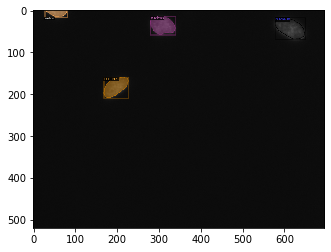

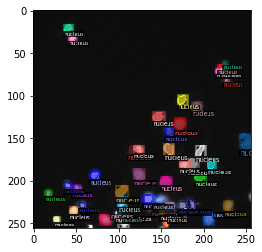

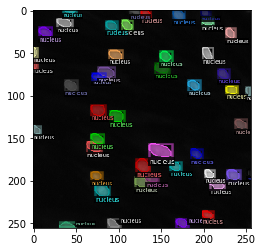

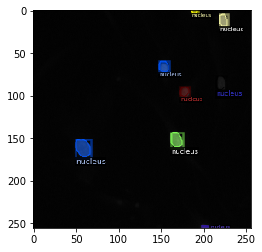

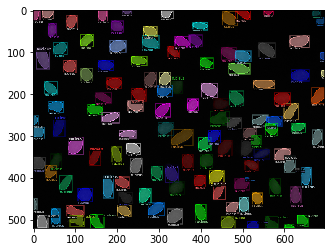

In [70]:
#for d in random.sample(dataset_dicts_nuclei, 3):
for d in dataset_dicts_nuclei[:5]:
    #print(d["file_name"])
    img = cv2.imread(str(d["file_name"]))
    #img = np.asarray(Image.open(p))
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

In [72]:
for d in dataset_dicts_nuclei:
    for a in d["annotations"]:
        polygon = a['segmentation']
        #print(len(polygon[0]))
        try:
            assert len(polygon[0]) % 2 == 0 and len(polygon[0]) >= 6
        except AssertionError:
            print(len(polygon[0]))

# Train

In [73]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [81]:
cfg = get_cfg()
model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"nuclei_train",)
cfg.DATASETS.TEST = (f"nuclei_valid",)
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset(balloons); you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.OUTPUT_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [82]:
trainer = DefaultTrainer(cfg) 

[03/20 15:29:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res


[03/20 15:34:16 d2.data.build]: Removed 0 images with no usable annotations. 688 images left.
[03/20 15:34:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  nucleus   | 46588        |
|            |              |
[03/20 15:34:16 d2.data.common]: Serializing 688 elements to byte tensors and concatenating them all ...
[03/20 15:34:17 d2.data.common]: Serialized dataset takes 28.91 MiB
[03/20 15:34:17 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/20 15:34:17 d2.data.build]: Using training sampler TrainingSampler


In [83]:
trainer.resume_or_load(resume=False)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [ ]:
trainer.train()

[03/20 15:34:56 d2.engine.train_loop]: Starting training from iteration 0
[03/20 15:34:57 d2.utils.memory]: Attempting to copy inputs of <detectron2.modeling.matcher.Matcher object at 0x7efc443565f8> to CPU due to CUDA OOM
[03/20 15:35:05 d2.utils.events]:  eta: 0:05:58  iter: 19  total_loss: 4.239  loss_cls: 0.644  loss_box_reg: 0.652  loss_mask: 0.694  loss_rpn_cls: 2.152  loss_rpn_loc: 0.201  time: 0.3652  data_time: 0.0378  lr: 0.000005  max_mem: 4914M
[03/20 15:35:12 d2.utils.events]:  eta: 0:05:36  iter: 39  total_loss: 4.053  loss_cls: 0.626  loss_box_reg: 0.676  loss_mask: 0.684  loss_rpn_cls: 1.803  loss_rpn_loc: 0.240  time: 0.3533  data_time: 0.0003  lr: 0.000010  max_mem: 4914M
[03/20 15:35:19 d2.utils.events]:  eta: 0:05:29  iter: 59  total_loss: 2.866  loss_cls: 0.591  loss_box_reg: 0.667  loss_mask: 0.666  loss_rpn_cls: 0.691  loss_rpn_loc: 0.188  time: 0.3510  data_time: 0.0003  lr: 0.000015  max_mem: 4914M
